<a href="https://colab.research.google.com/github/roccoderosa1982/taxi-drive-demand-forecast/blob/main/bolt_taxi_demand_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Riders Demand Supply Optimisation**

***Author.*** Rocco De Rosa

**Expected audience.** Data Scientist

**Problem Definition.** success of Bolt as a ride-hailing platform depends on a marketplace or efficient matching supply and demand in real-time. There are two sides in a ride-hailing marketplace: riders (demand) and drivers (supply). One of the challenges that we aim to solve is efficient supply allocation, so riders can always get a ride and drivers have stable earnings. Knowledge about how demand changes over time and space is crucial to comprehend supply Dynamics.


**Hypothesis and proposed solution.** In this analysis, I will verify with data whether the riders' demand is affected by location and time. If this is the case, I propose a demand forecasting system that relies on historical rides and can predict subsequent trip demand based on segmented city locations. The forecast presented here is on an hourly basis, but more granular time can be considered in the future. The drivers can receive at hourly base the new demand prediction correlated with more richer data stastitics (e.g. expected ride values) at different city locations. I assume that this could help the drivers plan their daily trips more effectively.

**Possible Risks.** The problem of ride demand forecasting is well-studied in literature and is still an open problem. One of the major issues in real applications is that capturing and optimizing the biases generated by drivers using the recommendation system is complicated. The data generated by the new scenario will be affected by the well-known problem of selection bias. This problem is generally leveraged by introducting exploitation-exploration startegies in the system. Moreover, here, I can only access rides that happened historically, whereas the real customer requests are absent. So I assume that the number of rides is a good proxy for the real rides ' demands.

**Extra data**

For further analysis it would be interesting to access more data sources such as

1. ***end time of rides*** to calculate the ride times from which we could generate statistics to show to drivers in order to plan the trips

2. ***postal codes*** in the analysis I used geohases for the sake of semplicity as postal code APIs are not free to use

3. ***weather conditions*** it is well known that weather also affects demand distribution so it could be another variable to improve the forecasting system

4. ***effective drive distances in km*** this is another variable that, coupled with ride duration can furnish more information to the drivers

5. ***customer ratings*** to verify if some locations may generate also different rating distribution for intrinsic reasons such as type of population and typical traffic conditions

6. ***customer requests*** to calculate the real riders demand, I suppose that there may be more requests than supply in certain times and locations and the contrary as well

7. ***time to pickup*** that can helps to optimise the recommendations

**Proposed analysis outline.**

In this analysis I

1. **Load and transform the data.** The data is loaded, validated, and transformed to be suitable for the presented analysis

2. **Exploratory Data Analysis.** In this section, I generated some charts depicting information regarding the time and location statistics of a number of rides and values. The data showed a good correlation between ride demands and values depending on time and location, which excused the proposed forecasting solution exploration.

3. **Proposed Forecasting modeling solution and predicted performances.** This section presents and evaluates a basic forecasting model based on ARIMA.

4. **Further considerations.** In this section is proposed how I would design, deploy, experiment and communicate such system in production.

**Notes.** This is only an early stage analysis where a time-box on the execution was set to about 8 hours. The study and methodology presented are essential only to verify the potential of such a system. The code here is not optimized and not perfectly cleaned. I preferred to invest time in reading a few literature papers on related problems and try some more sophisticated techniques that were only explored (cluster locations by postal codes and clustering methods, which are not present here as they required more time to be carefully checked). Also, I use the ride statistics as a proxy for the real customer demand, as the latter is unavailable in the data.

# **Load Data**

In [ ]:
#packages installations

%pip install pydantic
%pip install holidays
%pip install geohash2
%pip install plotly --upgrade
%pip install folium
%pip install pmdarima

  Preparing metadata (setup.py) ... done
  Created wheel for geohash2: filename=geohash2-1.1-py3-none-any.whl size=15544 sha256=069163c01951778fd8db88f068e13697ac260ea4180a2b3dc5b011da12cf5cbc
  Stored in directory: /root/.cache/pip/wheels/c0/21/8d/fe65503f4f439aef35193e5ec10a14adc945e20ff87eb35895
Successfully built geohash2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.4 MB/s eta 0:00:00


In [ ]:
#imports

import pandas as pd
from pydantic import BaseModel, ValidationError, field_validator
from datetime import datetime
import geohash2
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde
import numpy as np
import plotly.express as px
import holidays
from PIL import Image
from IPython.display import display
import os
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import folium
from IPython.display import IFrame
from sklearn.linear_model import LinearRegression


In [ ]:
#here we import the data and verify is consistent and imported in the useful types

# Define the schema for the DataFrame using Pydantic
class Ride(BaseModel):
    start_time: datetime
    start_lat: float
    start_lng: float
    end_lat: float
    end_lng: float
    ride_value: float

    @field_validator('*', mode='before')
    def check_empty_strings(cls, v):
        if v == '':
            raise ValueError('Empty strings are not allowed')
        return v

    @field_validator('start_lat', 'end_lat')
    def validate_latitude(cls, v):
        if not -90 <= v <= 90:
            raise ValueError('Latitude must be between -90 and 90')
        return v

    @field_validator('start_lng', 'end_lng')
    def validate_longitude(cls, v):
        if not -180 <= v <= 180:
            raise ValueError('Longitude must be between -180 and 180')
        return v

# Initialize lists to hold good lines and bad lines
data = []
bad_lines = []

# Read the CSV file line by line
with open('/content/drive/MyDrive/datasets/robotex5.csv', 'r') as file:
    for line_no, line in enumerate(file, start=0):
        # Skip the header line
        if line_no == 0:
            continue
        # Split the line into fields
        fields = line.strip().split(',')
        # Create a dictionary with the fields and their corresponding column names
        row_data = dict(zip(Ride.__fields__.keys(), fields))
        try:
            # Remove the last three digits from the start_time string to remove milliseconds
            start_time_str = row_data['start_time'][:-3]
            # Convert the start_time string to a datetime object
            row_data['start_time'] = datetime.strptime(start_time_str, '%Y-%m-%d %H:%M:%S.%f')
            # Validate the row data against the schema
            validated_data = Ride(**row_data)
            # If validation is successful, add the validated data to the cleaned_lines list
            data.append(validated_data.dict())
        except ValueError as e:
            # If the conversion or validation fails, add the line number and error message to the bad_lines list
            bad_lines.append([line_no, line, str(e)])
            # Print the bad line
            print(f"Bad Line {line_no}: {line.strip()} - {str(e)}")

# Create DataFrames for correct lines and bad lines
data = pd.DataFrame(data).drop_duplicates()
bad_lines_df = pd.DataFrame(bad_lines, columns=['line_number', 'line_content', 'error'])

In [ ]:
data.head(100)

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.518250
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.507500
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.190250
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.756000
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.271000
...,...,...,...,...,...,...
95,2022-03-17 13:13:49.106000,59.430082,24.732861,59.397580,24.701488,1.002143
96,2022-03-04 05:22:09.938659,59.444146,24.746704,59.417197,24.728612,0.788750
97,2022-03-24 09:27:21.306401,59.442461,24.735132,59.399066,24.704533,1.276750
98,2022-03-27 21:06:09.953579,59.383971,24.672836,59.432459,24.760703,1.815500


In [ ]:
data.shape

(622646, 6)

In [ ]:
bad_lines_df.head()

,line_number,line_content,error


In [ ]:
bad_lines_df.shape

(0, 3)

In [ ]:
# check id any missing value
data.isna().sum()

start_time    0
start_lat     0
start_lng     0
end_lat       0
end_lng       0
ride_value    0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 622646 entries, 0 to 627209
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   start_time  622646 non-null  datetime64[ns]
 1   start_lat   622646 non-null  float64       
 2   start_lng   622646 non-null  float64       
 3   end_lat     622646 non-null  float64       
 4   end_lng     622646 non-null  float64       
 5   ride_value  622646 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 33.3 MB


In [ ]:
data.describe()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
count,622646,622646.000000,622646.000000,622646.000000,622646.000000,622646.000000
mean,2022-03-15 18:59:21.545893376,59.428683,24.743474,59.397579,24.724682,2.268597
min,2022-03-01 00:00:07.936317,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,2022-03-09 00:03:57.959799552,59.418812,24.713154,59.415213,24.707899,0.545250
50%,2022-03-16 08:22:42.513948160,59.432070,24.744677,59.430697,24.744334,1.059000
75%,2022-03-22 21:29:45.173893376,59.439024,24.768124,59.439262,24.773922,1.712000
max,2022-03-28 23:59:53.175658,59.566998,24.973743,61.552744,144.966110,3172.701000
std,NaN,0.021761,0.056870,1.397846,1.656725,45.053886


Data looks reasonable.

**Feature Extraction.** I calculate some variables here that could be interesting to evaluate against the targets.

In [ ]:
# Initialize the holidays for Estonia
ee_holidays = holidays.country_holidays('EE')

# Function to determine if it's a weekend
def is_weekend(date):
    return date.weekday() >= 5  # 5 and 6 correspond to Saturday and Sunday

# Function to determine the time of day
def determine_time_of_day(hour):
    if 5 <= hour < 8:
        return 'Early Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 15:
        return 'Lunch'
    elif 15 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

# Function to check if a date is a holiday
def is_holiday(date):
    return date in ee_holidays

# Add new columns
data['is_weekend'] = data['start_time'].apply(is_weekend)
data['day_of_week'] = data['start_time'].dt.day_name()
data['is_holiday'] = data['start_time'].apply(is_holiday)
data['time_of_day'] = data['start_time'].dt.hour.apply(determine_time_of_day)
data.head(10)

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,is_weekend,day_of_week,is_holiday,time_of_day
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,True,Sunday,False,Afternoon
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,False,Thursday,False,Morning
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,True,Sunday,False,Lunch
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,False,Thursday,False,Morning
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,True,Sunday,False,Night
5,2022-03-02 07:17:34.858783,59.433606,24.712736,59.435205,24.748843,0.50275,False,Wednesday,False,Early Morning
6,2022-03-17 11:08:25.117959,59.398960,24.710864,59.440976,24.760222,1.35200,False,Thursday,False,Morning
7,2022-03-18 14:34:56.333676,59.416808,24.799002,59.406496,24.683917,1.62200,False,Friday,False,Lunch
8,2022-03-13 19:19:32.659761,59.432321,24.760523,59.423296,24.749209,0.29550,True,Sunday,False,Evening
9,2022-03-17 16:20:20.028387,59.410783,24.721219,59.439901,24.771756,1.06975,False,Thursday,False,Afternoon


In [ ]:
data.query('is_holiday == True').head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,is_weekend,day_of_week,is_holiday,time_of_day


The available dates do not include any public holidays, so I will remove this information.

In [ ]:
data.drop('is_holiday',axis=1, inplace=True)
data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,is_weekend,day_of_week,time_of_day
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,True,Sunday,Afternoon
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,False,Thursday,Morning
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,True,Sunday,Lunch
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,False,Thursday,Morning
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,True,Sunday,Night


In [ ]:
data.start_time.min()

Timestamp('2022-03-01 00:00:07.936317')

In [ ]:
data.start_time.max()

Timestamp('2022-03-28 23:59:53.175658')

**Cluster City Areas**

I have tried to get postal codes using the [geopy](https://geopy.readthedocs.io/en/stable/) library, but I had an issue with the API connection. I have also tried to use k-means clustering based on DBSCAN on several metric spaces, but I could not find a reasonable solution quickly. I decided to go for geohashes that are fast and simple to calculate. It is a naive but good enough way to verify that different locations have different demand distributions.

In [ ]:
# Function to create geohash from longitude and latitude
def create_geohash(lat, lng, precision=5):
    full_geohash = geohash2.encode(lat, lng)
    return full_geohash[:precision]

# Apply the function to each row and create a new column 'geohash'
data['geohash_start'] = data.apply(lambda row: create_geohash(row['start_lat'], row['start_lng']), axis=1)
data['geohash_end'] = data.apply(lambda row: create_geohash(row['end_lat'], row['end_lng']), axis=1)

# Display the first few rows of the DataFrame
data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,is_weekend,day_of_week,time_of_day,geohash_start,geohash_end
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,True,Sunday,Afternoon,ud99c,ud9dt
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,False,Thursday,Morning,ud9d5,ud9d5
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,True,Sunday,Lunch,ud9d5,ud9d5
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,False,Thursday,Morning,ud99c,ud99b
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,True,Sunday,Night,ud9d5,ud9dq


In [ ]:
data['geohash_start'].value_counts().head(10)

geohash_start
ud9d5    224808
ud9d4    132631
ud99c     48413
ud9dh     44268
ud99f     43558
ud9dj     22562
ud9d1     21026
ud99b     13594
ud9d0     12963
ud9dn     11432
Name: count, dtype: int64

In [ ]:
data['geohash_start'].value_counts().sum()

622646

In [ ]:
# For the sake of simplicity let's consider only the greater generated clusters for start rides

# Step 1: Get the three highest count 'geohash_start' values
cons_n=5
top_n_geohashes = data['geohash_start'].value_counts().head(cons_n).index.tolist()


# Step 2: Filter the DataFrame to include only rows where 'geohash_start' is in the top three
filtered_data = data[data['geohash_start'].isin(top_n_geohashes)]

filtered_data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,is_weekend,day_of_week,time_of_day,geohash_start,geohash_end
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,True,Sunday,Afternoon,ud99c,ud9dt
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,False,Thursday,Morning,ud9d5,ud9d5
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,True,Sunday,Lunch,ud9d5,ud9d5
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,False,Thursday,Morning,ud99c,ud99b
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,True,Sunday,Night,ud9d5,ud9dq


In [ ]:
# Define a function to map categorical values to colors
def color_mapper(category):
    # Simple hash function to generate a color for each category
    return '#{:06x}'.format(hash(category) & 0xFFFFFF)

# Create a map centered around the mean of all start points
mean_lat = filtered_data['start_lat'].mean()
mean_lng = filtered_data['start_lng'].mean()
m = folium.Map(location=[mean_lat, mean_lng], zoom_start=12)

# Group the data by 'geohash_start' and sample 100 rows from each group
sampled_data = filtered_data.groupby('geohash_start').apply(lambda x: x.sample(n=100) if len(x) >= 100 else x).reset_index(drop=True)

# Add markers to the map for each geolocation
for index, row in sampled_data.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=5,
        color=color_mapper(row['geohash_start']),
        fill=True,
        fill_color=color_mapper(row['geohash_start']),
        popup=row['geohash_start']  # Show the geohash_start value in a popup
    ).add_to(m)

# Place a label on the map for a random sample from each geohash_start area
for geohash, group in sampled_data.groupby('geohash_start'):
    if not group.empty:
        random_sample = group.sample(n=1).iloc[0]
        folium.Marker(
            location=[random_sample['start_lat'], random_sample['start_lng']],
            icon=folium.Icon(color='black'),
            popup=f"Label for {geohash}"
        ).add_to(m)

# Save the map to an HTML file
m.save('geolocation_map.html')

<ipython-input-21-97fa829c58ef>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(desired_size, Image.ANTIALIAS)


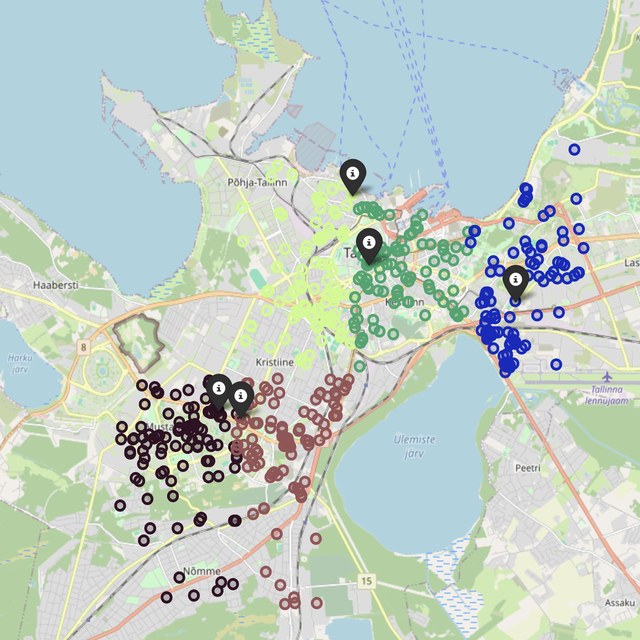

In [ ]:
#Let's read the resulting clustering file (i have saved it from the html manually)

# Replace 'path_to_your_image.png' with the actual path to your image file in Google Drive
image_path = '/content/drive/MyDrive/Colab Notebooks/Screenshot 2024-05-13 at 15.34.04.png'

# Define the desired size
desired_size = (128*5, 128*5)  # Example size: 128x128 pixels


# Check if the file exists at the specified path
if os.path.isfile(image_path):
    # Open the image file using PIL
    image = Image.open(image_path)

    # Resize the image
    image = image.resize(desired_size, Image.ANTIALIAS)


    # Display the image
    display(image)
else:
    print("Image file not found at the specified path.")

The clustering makes sense, indeed the colors depict different selected areas.

In [ ]:
filtered_data.shape

(493678, 11)

In [ ]:
sorted(filtered_data['start_time'].dt.date.unique())

[datetime.date(2022, 3, 1),
 datetime.date(2022, 3, 2),
 datetime.date(2022, 3, 3),
 datetime.date(2022, 3, 4),
 datetime.date(2022, 3, 5),
 datetime.date(2022, 3, 6),
 datetime.date(2022, 3, 7),
 datetime.date(2022, 3, 8),
 datetime.date(2022, 3, 9),
 datetime.date(2022, 3, 10),
 datetime.date(2022, 3, 11),
 datetime.date(2022, 3, 12),
 datetime.date(2022, 3, 13),
 datetime.date(2022, 3, 14),
 datetime.date(2022, 3, 15),
 datetime.date(2022, 3, 16),
 datetime.date(2022, 3, 17),
 datetime.date(2022, 3, 18),
 datetime.date(2022, 3, 19),
 datetime.date(2022, 3, 20),
 datetime.date(2022, 3, 21),
 datetime.date(2022, 3, 22),
 datetime.date(2022, 3, 23),
 datetime.date(2022, 3, 24),
 datetime.date(2022, 3, 25),
 datetime.date(2022, 3, 26),
 datetime.date(2022, 3, 27),
 datetime.date(2022, 3, 28)]

Let's generate the daily time series

In [ ]:
#Let's extract day and hour to generate daily time series

filtered_data['day'] = filtered_data['start_time'].dt.date
filtered_data['hour'] = filtered_data['start_time'].dt.hour

# Get the first X unique days sorted in ascending order
cons_days = len(filtered_data['day'].unique())
considered_days = sorted(filtered_data['day'].unique())[:cons_days]
# Filter the DataFrame for the considered days
filtered_data = filtered_data[filtered_data['day'].isin(considered_days)]

filtered_data.head()

<ipython-input-24-db385aead3fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['day'] = filtered_data['start_time'].dt.date
<ipython-input-24-db385aead3fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour'] = filtered_data['start_time'].dt.hour


,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,is_weekend,day_of_week,time_of_day,geohash_start,geohash_end,day,hour
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,True,Sunday,Afternoon,ud99c,ud9dt,2022-03-06,15
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,False,Thursday,Morning,ud9d5,ud9d5,2022-03-10,11
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,True,Sunday,Lunch,ud9d5,ud9d5,2022-03-06,14
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,False,Thursday,Morning,ud99c,ud99b,2022-03-03,9
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,True,Sunday,Night,ud9d5,ud9dq,2022-03-06,0


In this analysis I will not consider the drop-off. In the future, it is possible to consider them as reacher information for the drivers to know, for example, the predicted demand minus the predicted taxi already in a location (that dropped customers).

In [ ]:
# Group the data by 'geohash_start', 'day', 'hour'
grouped = filtered_data.groupby(['geohash_start', 'day', 'hour']).agg({
    'start_time': 'count',
    'ride_value': 'mean'
}).reset_index()

# Rename the columns
grouped.columns = ['geohash_start', 'day', 'hour', 'num_rides', 'avg_ride_value']

# Filter out days where any hour has zero rides to consider only complete time series
grouped = grouped[grouped['num_rides'] != 0]

# Reset the index
grouped = grouped.reset_index(drop=True)

# Filter out days that do not have all 24 hours with a value
days_with_all_hours = grouped.groupby(['geohash_start', 'day']).filter(lambda x: len(x['hour'].unique()) == 24)

# Reset the index
days_with_all_hours = days_with_all_hours.reset_index(drop=True)

# Merge the original dataframe to get the 'is_weekend', 'day_of_week', 'time_of_day' columns
final_df = pd.merge(days_with_all_hours, filtered_data[['geohash_start', 'day', 'hour', 'is_weekend', 'day_of_week', 'time_of_day']], on=['geohash_start', 'day', 'hour'], how='left')

# Drop duplicates if any
final_df = final_df.drop_duplicates()

# Reset the index
final_df = final_df.reset_index(drop=True)

# Display the first 100 rows of the final dataframe
final_df.head(100)

,geohash_start,day,hour,num_rides,avg_ride_value,is_weekend,day_of_week,time_of_day
0,ud99c,2022-03-01,0,39,2.293737,False,Tuesday,Night
1,ud99c,2022-03-01,1,23,1.251163,False,Tuesday,Night
2,ud99c,2022-03-01,2,23,1.745783,False,Tuesday,Night
3,ud99c,2022-03-01,3,15,1.600233,False,Tuesday,Night
4,ud99c,2022-03-01,4,30,1.592833,False,Tuesday,Night
...,...,...,...,...,...,...,...,...
95,ud99c,2022-03-04,23,51,1.567520,False,Friday,Night
96,ud99c,2022-03-05,0,26,1.755096,True,Saturday,Night
97,ud99c,2022-03-05,1,24,1.249167,True,Saturday,Night
98,ud99c,2022-03-05,2,21,1.399643,True,Saturday,Night


In [ ]:
final_df['day'].unique()

array([datetime.date(2022, 3, 1), datetime.date(2022, 3, 2),
       datetime.date(2022, 3, 3), datetime.date(2022, 3, 4),
       datetime.date(2022, 3, 5), datetime.date(2022, 3, 6),
       datetime.date(2022, 3, 7), datetime.date(2022, 3, 8),
       datetime.date(2022, 3, 9), datetime.date(2022, 3, 10),
       datetime.date(2022, 3, 11), datetime.date(2022, 3, 12),
       datetime.date(2022, 3, 13), datetime.date(2022, 3, 14),
       datetime.date(2022, 3, 15), datetime.date(2022, 3, 16),
       datetime.date(2022, 3, 17), datetime.date(2022, 3, 18),
       datetime.date(2022, 3, 19), datetime.date(2022, 3, 20),
       datetime.date(2022, 3, 21), datetime.date(2022, 3, 22),
       datetime.date(2022, 3, 23), datetime.date(2022, 3, 24),
       datetime.date(2022, 3, 25), datetime.date(2022, 3, 26),
       datetime.date(2022, 3, 27), datetime.date(2022, 3, 28)],
      dtype=object)

**Exploratory Data Analysis**

Let's have a look on the generated time series if they make sense or not over different locations and times

In [ ]:
# Get unique geohash_start values
geohash_starts = final_df['geohash_start'].unique()

# Iterate over each geohash_start
for geohash in geohash_starts:
    # Filter the data for the current geohash_start
    geohash_data = final_df[final_df['geohash_start'] == geohash]

    # Get unique days for the current geohash_start
    max_days_plot = 7
    days = geohash_data['day'].unique()[:max_days_plot]

    # Iterate over each day
    for day in days:
        # Filter the data for the current day
        day_data = geohash_data[geohash_data['day'] == day]

        # Determine if the day is a weekend
        is_weekend = 'Weekend' if day_data['is_weekend'].any() else 'Weekday'

        # Determine the day of the week
        day_of_week = day_data['day_of_week'].iloc[0]  # Assuming all values are the same for the day

        # Create a figure with two subplots
        fig = make_subplots(rows=1, cols=2, subplot_titles=("Number of Rides", "Average Ride Value"))

        # Create the time series for num_rides
        fig.add_trace(go.Scatter(x=day_data['hour'], y=day_data['num_rides'], mode='lines+markers', name='Number of Rides'), row=1, col=1)

        # Create the time series for avg_ride_value
        fig.add_trace(go.Scatter(x=day_data['hour'], y=day_data['avg_ride_value'], mode='lines+markers', name='Average Ride Value'), row=1, col=2)

        # Update layout for both subplots
        fig.update_layout(title_text=f'Number of Rides and Average Ride Value for {geohash} on {day} ({is_weekend}, {day_of_week})')
        fig.update_xaxes(title_text="Hour", row=1, col=1)
        fig.update_xaxes(title_text="Hour", row=1, col=2)
        fig.update_yaxes(title_text="Number of Rides", row=1, col=1)
        fig.update_yaxes(title_text="Average Ride Value", row=1, col=2)

        # Show the plot
        fig.show()

The number of rides in the time series is reasonable, and it is evident that there are patterns over time during the day and the week, depending on the location.

The time series of the ride values present weak patterns and are probably very complicated to forecast precisely.

In [ ]:
#Let's check now some statistics around the day of the week

# Define the order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Iterate over each geohash_start
for geohash in geohash_starts:
    # Filter the data for the current geohash_start
    geohash_data = final_df[final_df['geohash_start'] == geohash]

    # Calculate the average ride counts and average ride values for each day of the week
    avg_rides_by_day = geohash_data.groupby('day_of_week')['num_rides'].mean().reset_index()
    avg_values_by_day = geohash_data.groupby('day_of_week')['avg_ride_value'].mean().reset_index()

    # Sort the data by day_of_week
    avg_rides_by_day['day_of_week'] = pd.Categorical(avg_rides_by_day['day_of_week'], categories=day_order, ordered=True)
    avg_values_by_day['day_of_week'] = pd.Categorical(avg_values_by_day['day_of_week'], categories=day_order, ordered=True)

    # Sort the dataframes
    avg_rides_by_day = avg_rides_by_day.sort_values('day_of_week')
    avg_values_by_day = avg_values_by_day.sort_values('day_of_week')

    # Create a figure with two subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Average Number of Rides", "Average Ride Value"))

    # Create the bar chart for average number of rides
    fig.add_trace(go.Bar(x=avg_rides_by_day['day_of_week'], y=avg_rides_by_day['num_rides'], name='Average Number of Rides'), row=1, col=1)

    # Create the bar chart for average ride value
    fig.add_trace(go.Bar(x=avg_values_by_day['day_of_week'], y=avg_values_by_day['avg_ride_value'], name='Average Ride Value'), row=1, col=2)

    # Update layout for both subplots
    fig.update_layout(title_text=f'Average Number of Rides and Average Ride Value for {geohash} by Day of the Week')
    fig.update_xaxes(title_text="Day of the Week", row=1, col=1)
    fig.update_xaxes(title_text="Day of the Week", row=1, col=2)
    fig.update_yaxes(title_text="Average Number of Rides", row=1, col=1)
    fig.update_yaxes(title_text="Average Ride Value", row=1, col=2)

    # Show the plot
    fig.show()

It is evident that there are differences in ride number expectations depending on the weekdays. For example, Saturdays present a higher average ride number in all locations. I can try to use this variable as an exogenous in forecasting modeling. The number of rides distribution is quite consistent over different locations apart from the magnitudes. There are also evident difference patterns in the ride value averages over different locations.

In [ ]:
#Let's see the averages and median of rides during the day at different locations

# Iterate over each geohash_start
for geohash in geohash_starts:
    # Filter the data for the current geohash_start
    geohash_data = final_df[final_df['geohash_start'] == geohash]

    # Calculate the average and median number of rides and average and median ride values for each hour of the day
    avg_rides_by_hour = geohash_data.groupby('hour')['num_rides'].mean().reset_index()
    median_rides_by_hour = geohash_data.groupby('hour')['num_rides'].median().reset_index()
    avg_values_by_hour = geohash_data.groupby('hour')['avg_ride_value'].mean().reset_index()
    median_values_by_hour = geohash_data.groupby('hour')['avg_ride_value'].median().reset_index()

    # Create a figure for average and median number of rides
    fig_rides = go.Figure()
    fig_rides.add_trace(go.Bar(x=avg_rides_by_hour['hour'], y=avg_rides_by_hour['num_rides'], name='Average Number of Rides'))
    fig_rides.add_trace(go.Bar(x=median_rides_by_hour['hour'], y=median_rides_by_hour['num_rides'], name='Median Number of Rides'))
    fig_rides.update_layout(title_text=f'Average and Median Number of Rides for {geohash} by Hour of the Day', xaxis_title="Hour of the Day", yaxis_title="Number of Rides")
    fig_rides.show()

    # Create a figure for average and median ride value
    fig_values = go.Figure()
    fig_values.add_trace(go.Bar(x=avg_values_by_hour['hour'], y=avg_values_by_hour['avg_ride_value'], name='Average Ride Value'))
    fig_values.add_trace(go.Bar(x=median_values_by_hour['hour'], y=median_values_by_hour['avg_ride_value'], name='Median Ride Value'))
    fig_values.update_layout(title_text=f'Average and Median Ride Value for {geohash} by Hour of the Day', xaxis_title="Hour of the Day", yaxis_title="Ride Value")
    fig_values.show()

I can observe that mean and variance are pretty similar for num of rides but can be very different for ride values. This means that the distributions of ride values are skewed and present possible outliers. Let's check the sampled distributions of ride numbers and values..

In [ ]:
# Define a color palette for the geohash areas
color_palette = px.colors.qualitative.Plotly

# Create a subplot with shared x-axis for the fitted distributions plot
fig_distributions = make_subplots(rows=1, cols=1, shared_xaxes=True, subplot_titles=('Fitted Distributions'))

# Group by 'geohash_start' and create a fitted distribution for each group
for idx, (geohash, group) in enumerate(final_df.groupby('geohash_start')):
    # Fit a Gaussian KDE to the data
    kde = gaussian_kde(group['avg_ride_value'])
    # Create a range of values to evaluate the KDE
    x_vals = np.linspace(group['avg_ride_value'].min(), group['avg_ride_value'].max(), 100)
    # Calculate the y-values for the KDE
    y_vals = kde(x_vals)
    # Create a scatter plot for the fitted distribution
    fitted_dist = go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='lines',
        name=geohash,
        line=dict(color=color_palette[idx % len(color_palette)], width=2)  # Cycle through the color palette and increase line width
    )
    # Add the fitted distribution to the subplot
    fig_distributions.add_trace(fitted_dist, row=1, col=1)

    # Calculate mode, mean, and median
    mode = group['avg_ride_value'].mode()[0]
    mean = group['avg_ride_value'].mean()
    median = group['avg_ride_value'].median()

    # Calculate the y-value at the mode, mean, and median
    mode_y = kde(mode)[0]
    mean_y = kde(mean)[0]
    median_y = kde(median)[0]

    # Add vertical lines for mode, mean, and median
    fig_distributions.add_shape(type='line', x0=mode, y0=0, x1=mode, y1=mode_y, yref='y',
                                line=dict(color=color_palette[idx % len(color_palette)], width=2, dash='dash'), row=1, col=1)
    fig_distributions.add_shape(type='line', x0=mean, y0=0, x1=mean, y1=mean_y, yref='y',
                                line=dict(color=color_palette[idx % len(color_palette)], width=2, dash='dot'), row=1, col=1)
    fig_distributions.add_shape(type='line', x0=median, y0=0, x1=median, y1=median_y, yref='y',
                                line=dict(color=color_palette[idx % len(color_palette)], width=2, dash='dashdot'), row=1, col=1)

    # Add labels for mode, mean, and median
    fig_distributions.add_annotation(x=mode, y=mode_y, text="Mode", showarrow=False,
                                     font=dict(color=color_palette[idx % len(color_palette)]), row=1, col=1)
    fig_distributions.add_annotation(x=mean, y=mean_y, text="Mean", showarrow=False,
                                     font=dict(color=color_palette[idx % len(color_palette)]), row=1, col=1)
    fig_distributions.add_annotation(x=median, y=median_y, text="Median", showarrow=False,
                                     font=dict(color=color_palette[idx % len(color_palette)]), row=1, col=1)

# Update layout for the fitted distributions plot
fig_distributions.update_layout(
    xaxis_title='Average Ride Value',
    yaxis_title='Density',
    showlegend=True,  # Show the legend
    legend=dict(title='Geohash Areas'),  # Title for the legend
    xaxis=dict(range=[0, 8])  # Zoom in on the x-axis to show values up to 8
)

# Show the fitted distributions plot
fig_distributions.show()

The ride values distribution presents long tiles (positively skewed); indeed, all the means are greater than the medians.


In [ ]:
# Let's check number of rides distributions..

# Create a subplot with shared x-axis for the fitted distributions plot
fig_distributions = make_subplots(rows=1, cols=1, shared_xaxes=True, subplot_titles=('Fitted Distributions for num_rides'))

# Group by 'geohash_start' and create a fitted distribution for each group
for idx, (geohash, group) in enumerate(final_df.groupby('geohash_start')):
    # Fit a Gaussian KDE to the data
    kde = gaussian_kde(group['num_rides'])
    # Create a range of values to evaluate the KDE
    x_vals = np.linspace(group['num_rides'].min(), group['num_rides'].max(), 100)
    # Calculate the y-values for the KDE
    y_vals = kde(x_vals)
    # Create a scatter plot for the fitted distribution
    fitted_dist = go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='lines',
        name=geohash,
        line=dict(color=color_palette[idx % len(color_palette)], width=2)  # Cycle through the color palette and increase line width
    )
    # Add the fitted distribution to the subplot
    fig_distributions.add_trace(fitted_dist, row=1, col=1)

    # Calculate mode, mean, and median
    mode = group['num_rides'].mode()[0]
    mean = group['num_rides'].mean()
    median = group['num_rides'].median()

    # Calculate the y-value at the mode, mean, and median
    mode_y = kde(mode)[0]
    mean_y = kde(mean)[0]
    median_y = kde(median)[0]

    # Add vertical lines for mode, mean, and median
    fig_distributions.add_shape(type='line', x0=mode, y0=0, x1=mode, y1=mode_y, yref='y',
                                line=dict(color=color_palette[idx % len(color_palette)], width=2, dash='dash'), row=1, col=1)
    fig_distributions.add_shape(type='line', x0=mean, y0=0, x1=mean, y1=mean_y, yref='y',
                                line=dict(color=color_palette[idx % len(color_palette)], width=2, dash='dot'), row=1, col=1)
    fig_distributions.add_shape(type='line', x0=median, y0=0, x1=median, y1=median_y, yref='y',
                                line=dict(color=color_palette[idx % len(color_palette)], width=2, dash='dashdot'), row=1, col=1)

    # Add labels for mode, mean, and median
    fig_distributions.add_annotation(x=mode, y=mode_y, text="Mode", showarrow=False,
                                     font=dict(color=color_palette[idx % len(color_palette)]), row=1, col=1)
    fig_distributions.add_annotation(x=mean, y=mean_y, text="Mean", showarrow=False,
                                     font=dict(color=color_palette[idx % len(color_palette)]), row=1, col=1)
    fig_distributions.add_annotation(x=median, y=median_y, text="Median", showarrow=False,
                                     font=dict(color=color_palette[idx % len(color_palette)]), row=1, col=1)

# Update layout for the fitted distributions plot
fig_distributions.update_layout(
    xaxis_title='Number of Rides',
    yaxis_title='Density',
    showlegend=True,  # Show the legend
    legend=dict(title='Geohash Areas'),  # Title for the legend
    #xaxis=dict(range=[0, 8])  # Zoom in on the x-axis to show values up to 8
)

# Show the fitted distributions plot
fig_distributions.show()

The distribution of the number of rides appears to be more normally distributed (means and medians are generally near), forming a symmetric bell curve. However, it seems to be bimodal, indicating a mix of two normally distributed sub-populations. This bimodal nature could be useful for more complex analyses, as identifying variables that decouple the two distributions may provide valuable insights for better modeling.

In [ ]:
#Let's see if, at different locations, the pick ride demands times are similar

# Calculate the average number of rides for each geohash_start and hour
average_rides = final_df.groupby(['geohash_start', 'hour'])['num_rides'].mean().reset_index()

# For each geohash_start, find the top 3 hours with the highest average num_rides
top_hours = average_rides.groupby('geohash_start')['num_rides'].nlargest(4).reset_index()
top_hours = top_hours.merge(average_rides, on=['geohash_start', 'num_rides'])

# Define a color palette for the bars
color_palette = px.colors.qualitative.Plotly

# Create a subplot for each geohash_start area
num_areas = len(top_hours['geohash_start'].unique())
fig = make_subplots(rows=num_areas, cols=1,
                    subplot_titles=[f'Geohash Area: {area}' for area in top_hours['geohash_start'].unique()])

# Create a bar chart for each geohash_start area
for idx, (area, group) in enumerate(top_hours.groupby('geohash_start')):
    # Sort the group by num_rides in descending order
    group = group.sort_values('num_rides', ascending=False)

    # Create a bar chart for the top 4 hours
    bar_chart = go.Bar(
        x=group['hour'] + 0.5 - 0.5 * (len(group) - 1),  # Center bars on the hour
        y=group['num_rides'],
        width=1,  # Set bar width to 1 for better visibility
        name=area,
        marker_color=color_palette[idx % len(color_palette)]  # Cycle through the color palette
    )

    # Add the bar chart to the subplot
    fig.add_trace(bar_chart, row=idx+1, col=1)

# Update layout for the subplots
fig.update_layout(
    title='Top 4 Hours with Highest Average Number of Rides for Each Geohash Area',
    xaxis_title='Hour',
    yaxis_title='Average Number of Rides',
    showlegend=False,  # Hide the legend since it's not necessary for this plot
    barmode='group',  # Group bars by hour within each geohash area
    xaxis=dict(
        tickmode='array',  # Set tick mode to array to specify exact ticks
        tickvals=list(range(24)),  # Set tick values to 0-23
        ticktext=[f'{h:02d}:00' for h in range(24)]  # Set tick text to 'HH:00' format
    )
)

# Set x-axis range for each subplot
for i in range(1, num_areas + 1):
    fig.update_xaxes(range=[0, 24], row=i, col=1)

# Show the plot
fig.show()

The data shows that different locations may have different rushing hours. This reinforces the precious information a forecasting system can give to drivers to help them plan their trips.


**Forecasting modeling**

We focus only on one of the city areas to demonstrate our ability to forecast taxi driver demand for a given day, time, and location. Our baseline solution will develop a unique forecasting model for each location in a production environment. At any given time of the day, taxi drivers can access real-time, updated forecasts of demand for the upcoming hours across various locations. This enables them to optimize their trips, for example, by moving to areas with higher demand.

In [ ]:
final_df.head(100)

,geohash_start,day,hour,num_rides,avg_ride_value,is_weekend,day_of_week,time_of_day
0,ud99c,2022-03-01,0,39,2.293737,False,Tuesday,Night
1,ud99c,2022-03-01,1,23,1.251163,False,Tuesday,Night
2,ud99c,2022-03-01,2,23,1.745783,False,Tuesday,Night
3,ud99c,2022-03-01,3,15,1.600233,False,Tuesday,Night
4,ud99c,2022-03-01,4,30,1.592833,False,Tuesday,Night
...,...,...,...,...,...,...,...,...
95,ud99c,2022-03-04,23,51,1.567520,False,Friday,Night
96,ud99c,2022-03-05,0,26,1.755096,True,Saturday,Night
97,ud99c,2022-03-05,1,24,1.249167,True,Saturday,Night
98,ud99c,2022-03-05,2,21,1.399643,True,Saturday,Night


In [ ]:
#Let's select one area

dataset = final_df[final_df['geohash_start'] == 'ud9d4']
dataset = dataset.drop('geohash_start', axis=1)
dataset.head(100)

,day,hour,num_rides,avg_ride_value,is_weekend,day_of_week,time_of_day
1344,2022-03-01,0,91,1.027250,False,Tuesday,Night
1345,2022-03-01,1,89,0.998199,False,Tuesday,Night
1346,2022-03-01,2,66,0.952383,False,Tuesday,Night
1347,2022-03-01,3,65,0.915919,False,Tuesday,Night
1348,2022-03-01,4,78,0.973538,False,Tuesday,Night
...,...,...,...,...,...,...,...
1439,2022-03-04,23,154,1.018563,False,Friday,Night
1440,2022-03-05,0,98,0.856862,True,Saturday,Night
1441,2022-03-05,1,80,1.092369,True,Saturday,Night
1442,2022-03-05,2,83,0.961630,True,Saturday,Night


In [ ]:
dataset.day.unique()

array([datetime.date(2022, 3, 1), datetime.date(2022, 3, 2),
       datetime.date(2022, 3, 3), datetime.date(2022, 3, 4),
       datetime.date(2022, 3, 5), datetime.date(2022, 3, 6),
       datetime.date(2022, 3, 7), datetime.date(2022, 3, 8),
       datetime.date(2022, 3, 9), datetime.date(2022, 3, 10),
       datetime.date(2022, 3, 11), datetime.date(2022, 3, 12),
       datetime.date(2022, 3, 13), datetime.date(2022, 3, 14),
       datetime.date(2022, 3, 15), datetime.date(2022, 3, 16),
       datetime.date(2022, 3, 17), datetime.date(2022, 3, 18),
       datetime.date(2022, 3, 19), datetime.date(2022, 3, 20),
       datetime.date(2022, 3, 21), datetime.date(2022, 3, 22),
       datetime.date(2022, 3, 23), datetime.date(2022, 3, 24),
       datetime.date(2022, 3, 25), datetime.date(2022, 3, 26),
       datetime.date(2022, 3, 27), datetime.date(2022, 3, 28)],
      dtype=object)

In [ ]:
#Let's see the generated data

def plot_time_series_with_trend(dataset, day_column, hour_column, y_column):
    # Create a copy of the DataFrame to avoid modifying the original data
    dataset_copy = dataset.copy()

    # Convert 'day' and 'hour' to a datetime format
    dataset_copy['datetime'] = pd.to_datetime(dataset_copy[day_column]) + pd.to_timedelta(dataset_copy[hour_column], unit='h')

    # Set 'datetime' as the index
    dataset_copy.set_index('datetime', inplace=True)

    # Drop the original 'day' and 'hour' columns
    dataset_copy.drop([day_column, hour_column], axis=1, inplace=True)

    # Fit a linear regression model to the data
    X = np.arange(len(dataset_copy)).reshape(-1, 1)  # Reshape to 2D array for sklearn
    y = dataset_copy[y_column].values
    model = LinearRegression().fit(X, y)

    # Predict the trend line
    trend = model.predict(X)

    # Create the time series line plot
    time_series_plot = go.Scatter(
        x=dataset_copy.index,
        y=dataset_copy[y_column],
        mode='lines',
        name=y_column,
        line=dict(color='blue')
    )

    # Create the trend line plot
    trend_plot = go.Scatter(
        x=dataset_copy.index,
        y=trend,
        mode='lines',
        name='Trend Line',
        line=dict(color='red'),
        showlegend=True  # Show the legend for the trend line
    )

    # Combine the plots into a single figure
    fig = go.Figure(data=[time_series_plot, trend_plot])

    # Customize the layout
    fig.update_layout(
        title=f'{y_column} Over Time with Trend Line',
        xaxis_title='Date and Time',
        yaxis_title=y_column,
        hovermode='x unified',  # Show date and time when hovering
        hoverlabel=dict(namelength=-1),  # Show all values in hover
        showlegend=True  # Show the legend
    )

    # Show the plot
    fig.show()

# Example usage:
# Assuming 'dataset' is your DataFrame and it has columns 'day', 'hour', and 'num_rides'
plot_time_series_with_trend(dataset, 'day', 'hour', 'num_rides')

The dataset makes sense. I observe a positive incremental trend.

In [ ]:
#Let's create now a dataset where we use 80% of the available days as train and the other days as test

def create_train_test_set(dataset, train_size_percentage):
    # Convert 'day' and 'hour' to a datetime format
    dataset['datetime'] = pd.to_datetime(dataset['day']) + pd.to_timedelta(dataset['hour'], unit='h')

    # Set 'datetime' as the index
    dataset.set_index('datetime', inplace=True)

    # Drop the original 'day' and 'hour' columns
    #dataset.drop(['day', 'hour'], axis=1, inplace=True)

    # Calculate the number of days in the dataset
    total_days = (dataset.index.max() - dataset.index.min()).days + 1

    # Calculate the number of days for the training set
    train_days = int(total_days * train_size_percentage / 100)

    # Calculate the cutoff date based on the number of days for the training set
    cutoff_date = dataset.index.min() + pd.DateOffset(days=train_days)

    # Split the data into train and test sets
    train = dataset.loc[dataset.index < cutoff_date]
    test = dataset.loc[dataset.index >= cutoff_date]

    # Ensure that we have full days in the training set
    train_days_count = train.resample('D').count()['num_rides']
    while train_days_count.iloc[-1] != 24:
        cutoff_date -= pd.DateOffset(days=1)
        train = dataset.loc[dataset.index < cutoff_date]
        test = dataset.loc[dataset.index >= cutoff_date]
        train_days_count = train.resample('D').count()['num_rides']

    # Ensure that we have full days in the testing set
    test_days_count = test.resample('D').count()['num_rides']
    while test_days_count.iloc[0] != 24:
        cutoff_date += pd.DateOffset(days=1)
        train = dataset.loc[dataset.index < cutoff_date]
        test = dataset.loc[dataset.index >= cutoff_date]
        test_days_count = test.resample('D').count()['num_rides']

    return train, test

# Example usage:
train, test = create_train_test_set(dataset, 80)

In [ ]:
train.head(100)

,day,hour,num_rides,avg_ride_value,is_weekend,day_of_week,time_of_day
datetime,,,,,,,
2022-03-01 00:00:00,2022-03-01,0,91,1.027250,False,Tuesday,Night
2022-03-01 01:00:00,2022-03-01,1,89,0.998199,False,Tuesday,Night
2022-03-01 02:00:00,2022-03-01,2,66,0.952383,False,Tuesday,Night
2022-03-01 03:00:00,2022-03-01,3,65,0.915919,False,Tuesday,Night
2022-03-01 04:00:00,2022-03-01,4,78,0.973538,False,Tuesday,Night
...,...,...,...,...,...,...,...
2022-03-04 23:00:00,2022-03-04,23,154,1.018563,False,Friday,Night
2022-03-05 00:00:00,2022-03-05,0,98,0.856862,True,Saturday,Night
2022-03-05 01:00:00,2022-03-05,1,80,1.092369,True,Saturday,Night


In [ ]:
#Let's check the resulting train and test set

def plot_time_series(dataset, day_column, hour_column, y_column, label):
    # Convert 'day' and 'hour' to a datetime format
    dataset['datetime'] = pd.to_datetime(dataset[day_column]) + pd.to_timedelta(dataset[hour_column], unit='h')

    # Set 'datetime' as the index
    dataset.set_index('datetime', inplace=True)

    # Drop the original 'day' and 'hour' columns
    dataset.drop([day_column, hour_column], axis=1, inplace=True)

    # Create the plot
    trace = go.Scatter(x=dataset.index, y=dataset[y_column], mode='lines', name=label)
    return trace

# Example usage with train and test sets:
train_trace = plot_time_series(train, 'day', 'hour', 'num_rides', 'Train')
test_trace = plot_time_series(test, 'day', 'hour', 'num_rides', 'Test')

# Combine the traces into a single plot
fig = go.Figure(data=[train_trace, test_trace])

# Customize the layout
fig.update_layout(
    title='Number of Rides Over Time',
    xaxis_title='Date and Time',
    yaxis_title='Number of Rides',
    hovermode='x unified',  # Show date and time when hovering
    hoverlabel=dict(namelength=-1),  # Show all values in hover
    showlegend=True  # Show the legend
)

# Show the plot
fig.show()

<ipython-input-40-b29642e35235>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-40-b29642e35235>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-40-b29642e35235>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-40-b29642e35235>:11: SettingWithCopyWarning:


A value is trying t

In [ ]:
train.head(200)

,num_rides,avg_ride_value,is_weekend,day_of_week,time_of_day
datetime,,,,,
2022-03-01 00:00:00,91,1.027250,False,Tuesday,Night
2022-03-01 01:00:00,89,0.998199,False,Tuesday,Night
2022-03-01 02:00:00,66,0.952383,False,Tuesday,Night
2022-03-01 03:00:00,65,0.915919,False,Tuesday,Night
2022-03-01 04:00:00,78,0.973538,False,Tuesday,Night
...,...,...,...,...,...
2022-03-09 03:00:00,63,1.044773,False,Wednesday,Night
2022-03-09 04:00:00,109,0.936279,False,Wednesday,Night
2022-03-09 05:00:00,169,0.994395,False,Wednesday,Early Morning


The train and test looks good.


**Forecasting porduction simulation.** I'm simulating an ARIMA forecasting model in production. The first model is produced using the training set and parameters are tuned. Possibly, the model can be re-tuned once a week.

The model is retrained every hour using real-time data. The forecasting model can be retrained every X hours, where X can be optimized in a production environment. The retraining schedule can be tuned depending on model performances.

In production, we would forecast the demand for each location every hour and send it to the drivers.

In [ ]:

# Tune the ARIMA model parameters only on the training set
# Assuming a linear trend, we use d=1 to make the time series stationary
model = auto_arima(train['num_rides'], start_p=1, start_q=1,
                   max_p=5, max_q=5, m=1,
                   start_P=0, seasonal=False,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

incremental_train = train.copy()

# Fit the model on the training data
model.fit(incremental_train['num_rides'])

# Initialize an empty DataFrame to store the predictions
predictions = pd.DataFrame(index=test.index, columns=['num_rides_predicted'])

# Initialize an empty DataFrame to store the actual values
actuals = pd.DataFrame(index=test.index, columns=['num_rides_actual'])

# Iterate over the test set, making predictions and updating the model
for t in range(len(test)):
    # Forecast the next hour
    forecast, conf_int = model.predict(n_periods=1, return_conf_int=True)

    # Store the prediction and actual value
    predictions.loc[test.index[t], 'num_rides_predicted'] = forecast[0]
    actuals.loc[test.index[t], 'num_rides_actual'] = test.iloc[t]['num_rides']

    # Print the prediction and actual value
    print(f"Predicted: {forecast[0]}, Actual: {test.iloc[t]['num_rides']}")

    # Assign the actual value to the training set for the next iteration
    # Ensure the new row has the same columns as the train DataFrame
    new_row = test.iloc[t].copy()
    incremental_train.loc[test.index[t]] = new_row

    # Retrain the model on the updated training set with the same parameters
    model.fit(incremental_train['num_rides'])

# Plot the training time series, predicted values, and actual values
train_plot = go.Scatter(x=incremental_train.index, y=incremental_train['num_rides'], name='Train', mode='lines')
predictions_plot = go.Scatter(x=predictions.index, y=predictions['num_rides_predicted'], name='Predictions', mode='lines')
actuals_plot = go.Scatter(x=actuals.index, y=actuals['num_rides_actual'], name='Actuals', mode='lines')

layout = go.Layout(title='ARIMA Forecast in Production Environment',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Number of Rides'))

fig = go.Figure(data=[train_plot, predictions_plot, actuals_plot], layout=layout)
fig.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5528.316, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5598.610, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5534.874, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5530.201, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5596.620, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5519.323, Time=1.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5517.326, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5528.206, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=5427.252, Time=0.62 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=1.83 s

In [ ]:
#let's check the generalisation performances..

def calculate_forecast_metrics(actuals, predictions):
    """
    Calculate various forecasting metrics.

    Parameters:
    actuals (pandas Series): Series of actual values.
    predictions (pandas Series): Series of predicted values.

    Returns:
    dict: Dictionary containing the calculated metrics.
    """
    # Calculate MAE
    mae = mean_absolute_error(actuals, predictions)

    # Calculate Bias
    bias = np.mean(predictions - actuals)

    # Calculate MSE
    mse = mean_squared_error(actuals, predictions)

    # Calculate RMSE
    rmse = np.sqrt(mse)

    # Calculate MAPE
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    # Return the metrics in a dictionary
    return {
        'MAE': mae,
        'Bias': bias,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

# Example usage:
# Assuming 'actuals' and 'predictions' are pandas Series with the actual and predicted values
metrics = calculate_forecast_metrics(actuals['num_rides_actual'], predictions['num_rides_predicted'])

# Print the metrics
for metric, value in metrics.items():
    print(f"{metric}: {value}")

MAE: 39.62837477404839
Bias: -1.5267489120483067
MSE: 2582.5292864608473
RMSE: 50.818591937015015
MAPE: 22.111911033761086


The performance of the baseline model looks promising as it can identify demand peaks during the day, despite not being excellent (I did not spend too much time on model tuning and selection). The model tend to under-estimate the rides (negative bias), this may due also at the positive increase trends of the time series.

Let's add some exogenous variables to see if they would improve the performances.

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from pmdarima.arima import auto_arima
import plotly.graph_objs as go

# Assuming 'train' and 'test' are your DataFrames and 'is_weekend', 'day_of_week', and 'time_of_day' are your exogenous variables

incremental_train = train.copy()
copy_test = test.copy()

# Convert 'day_of_week' and 'time_of_day' to categorical type
incremental_train['day_of_week'] = incremental_train['day_of_week'].astype('category')
incremental_train['time_of_day'] = incremental_train['time_of_day'].astype('category')
copy_test['day_of_week'] = copy_test['day_of_week'].astype('category')
copy_test['time_of_day'] = copy_test['time_of_day'].astype('category')

# Initialize one-hot encoders
encoder_day_of_week = OneHotEncoder(sparse=False)
encoder_time_of_day = OneHotEncoder(sparse=False)

# Fit encoders on the training data
encoder_day_of_week.fit(incremental_train[['day_of_week']])
encoder_time_of_day.fit(incremental_train[['time_of_day']])

# Transform the categorical variables into one-hot encoded variables
day_of_week_encoded = encoder_day_of_week.transform(incremental_train[['day_of_week']])
time_of_day_encoded = encoder_time_of_day.transform(incremental_train[['time_of_day']])

# Add the one-hot encoded variables to the training set
incremental_train[encoder_day_of_week.categories_[0]] = day_of_week_encoded
incremental_train[encoder_time_of_day.categories_[0]] = time_of_day_encoded

# Repeat the process for the test set
day_of_week_encoded_test = encoder_day_of_week.transform(copy_test[['day_of_week']])
time_of_day_encoded_test = encoder_time_of_day.transform(copy_test[['time_of_day']])

# Add the one-hot encoded variables to the test set
copy_test[encoder_day_of_week.categories_[0]] = day_of_week_encoded_test
copy_test[encoder_time_of_day.categories_[0]] = time_of_day_encoded_test

# Now 'day_of_week' and 'time_of_day' are one-hot encoded and can be used as exogenous variables
exogenous_columns = ['is_weekend'] + list(encoder_day_of_week.categories_[0]) + list(encoder_time_of_day.categories_[0])

# Tune the ARIMA model parameters only on the training set
# Include exogenous variables 'is_weekend', 'day_of_week', and 'time_of_day'
model = auto_arima(incremental_train['num_rides'], exogenous=incremental_train[exogenous_columns],
                   start_p=1, start_q=1, max_p=3, max_q=3, m=1,
                   start_P=0, seasonal=True,
                   d=None, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Initialize an empty DataFrame to store the predictions
predictions = pd.DataFrame(index=copy_test.index, columns=['num_rides_predicted'])

# Initialize an empty DataFrame to store the actual values
actuals = pd.DataFrame(index=copy_test.index, columns=['num_rides_actual'])

# Iterate over the test set, making predictions and updating the model
for t in range(len(copy_test)):
    # Forecast the next hour with exogenous variables
    forecast, conf_int = model.predict(n_periods=1,
                                       exogenous=copy_test[exogenous_columns].iloc[t],
                                       return_conf_int=True)

    # Store the prediction and actual value
    predictions.loc[copy_test.index[t], 'num_rides_predicted'] = forecast[0]
    actuals.loc[copy_test.index[t], 'num_rides_actual'] = copy_test.iloc[t]['num_rides']

    # Print the prediction and actual value
    print(f"Predicted: {forecast[0]}, Actual: {copy_test.iloc[t]['num_rides']}")


    # Assign the actual value to the training set for the next iteration
    # Ensure the new row has the same columns as the train DataFrame
    new_row = copy_test.iloc[t].copy()
    incremental_train.loc[copy_test.index[t]] = new_row


    # Update the model with the new observation without refitting it from scratch
    model.update(new_row['num_rides'], exogenous=new_row[exogenous_columns])

# Plot the training time series, predicted values, and actual values
train_plot = go.Scatter(x=incremental_train.index, y=incremental_train['num_rides'], name='Train', mode='lines')
predictions_plot = go.Scatter(x=predictions.index, y=predictions['num_rides_predicted'], name='Predictions', mode='lines')
actuals_plot = go.Scatter(x=actuals.index, y=actuals['num_rides_actual'], name='Actuals', mode='lines')

layout = go.Layout(title='ARIMA Forecast in Production Environment with exogenous variables',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Number of Rides'))

fig = go.Figure(data=[train_plot, predictions_plot, actuals_plot], layout=layout)
fig.show()

Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5528.316, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5598.610, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5534.874, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5530.201, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5596.620, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5519.323, Time=0.43 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5517.326, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5528.206, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=5427.252, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=1.02 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]    

In [ ]:
# previous values
# MAE: 39.62837477404839
# Bias: -1.5267489120483067
# MSE: 2582.5292864608473
# RMSE: 50.818591937015015
# MAPE: 22.111911033761086

# Print the metrics
for metric, value in metrics.items():
    print(f"{metric}: {value}")

MAE: 39.62837477404839
Bias: -1.5267489120483067
MSE: 2582.5292864608473
RMSE: 50.818591937015015
MAPE: 22.111911033761086


It seems exogenous variables are not helping for this particular baseline (unless I have made any mistake, for the sake of time, I end up here with the analysis). Indeed, the same predictions are obtained.

**Conclusion.** The forecasting system could be very useful for drivers in order to optimize the planning of the trips moving towards the higher picks of demands.

# **Describe how you would design and deploy such a model.**

We could use a cloud platform, in more detail we could use AWS services.
## Development

- **Versioning**: Use Git for version control. AWS CodeCommit can be used as a managed source control service that hosts private Git repositories.
- **Data Pipelines**: Use Apache Airflow for creating data pipelines.
- **Unit Testing**: Use PyTest for unit testing. Jenkins can be used as a continuous integration server to automate the testing process.

## Deployment

- **Containerization**: Use Docker for containerization. AWS Elastic Container Registry (ECR) can be used to store, manage, and deploy Docker container images.
- **Orchestration**: Use Kubernetes for orchestration. AWS Elastic Kubernetes Service (EKS) is a managed service.
- **CI/CD Pipelines**: Use AWS CodePipeline for continuous delivery.

## Re-training Pipelines

- **Data Storage**: Use AWS S3 for storing incoming data for retraining. AWS Glue can be used to prepare and load the data for analytics.
- **Retraining Trigger**: Use AWS Lambda to trigger the retraining process when new data is available. AWS CloudWatch can be used to schedule the Lambda function.
- **Retraining Process**: Use AWS SageMaker for training the model. It provides a Jupyter notebook instance for easy access to your data sources for exploration and analysis.

## Monitoring

- **Logging**: Use AWS CloudWatch for logging.
- **Metrics**: Use AWS CloudWatch for metrics. It collects and tracks metrics, sets alarms, and automatically reacts to changes in AWS resources.
- **Health Checks**: Use AWS Route 53 for health checks. It monitors the health and performance of your web applications, web servers, and other resources.

## API

- **RESTful API**: Use AWS API Gateway to expose your model as a RESTful API. It acts as a "front door" for applications to access data, business logic, or functionality from your back-end services.
- **Frontend Integration**: Use AWS Amplify for frontend integration. It provides a set of tools and services that enables mobile and front-end web developers to build secure, scalable full stack applications, powered by AWS.

## Documentation

- **API Documentation**: Use Swagger or OpenAPI for API documentation. AWS API Gateway can generate Swagger/OpenAPI definitions of your APIs.

## Maintenance

- **Regular Updates**: Use AWS Lambda to update your model with new data and retrain it as necessary.
- **Bug Fixes**: Use AWS CodeStar to manage your software development projects on AWS. It helps you quickly create, manage, and delete AWS resources necessary to develop and deploy your applications.


# **Describe how to communicate model recommendations to drivers.**

To effectively introduce this new feature and encourage its uptake, we can consider offering targeted training to a select group of drivers who will be part of the initial trial. We might also offer them a discount on platform fees as an incentive.

We should highlight the new tool's advantages, such as its potential for more trips, less downtime, and enhanced customer satisfaction.

We should Provide drivers with a trial period to familiarize themselves with the new tool and gather their feedback before they fully integrate it into their operations.

We can leverage success stories and testimonials from early users to foster trust and motivate broader adoption of the tool.

# **Think through and describe the design of the experiment  that would validate your solution for live operations taking into account marketplace specifics.**

Assuming this is the inaugural iteration of the recommendation tool, an A/B test can be devised to randomly assign riders to utilize the tool for a predetermined number of weeks. The duration will be determined through sample size estimation, leveraging historical data and pertinent metrics. The control group will consist of drivers operating without the tool, maintaining their usual business practices, while the variation group will include drivers equipped with the tool.

Primary metrics to gauge the effectiveness of the tool are:

1. **Driver Utilization Rate**: This metric will measure the proportion of time drivers are actively engaged in trips, both with and without the aid of the new tool. It is anticipated that this metric will strongly correlate with the experimentation on ride value forecasting, which is not encompassed within this baseline analysis.

2. **Trip Volume**: The count of trips completed by drivers employing the new tool will be compared to those not utilizing it. It is hypothesized that this metric will serve as the most indicative proxy for the proposed solution's efficacy.

Secondary metrics, serving as guardrails, may include:

1. **Passenger Satisfaction**: Passenger ratings will be analyzed to assess the quality of their experiences with drivers who have adopted the new tool versus those who have not.

2. **Cancellation Rate**: The proportion of trips canceled by both drivers and riders will be scrutinized to understand any potential impacts of the tool on trip reliability.

3. **Tool Utilization Rate**: The percentage of drivers who are actively navigating towards the recommended locations during their daily operations will be monitored to evaluate the tool's adoption and utility.

To ensure the validity of the A/B test:

1. **Tracking Implementation**: It is imperative to establish accurate tracking mechanisms to compute the selected metrics reliably.
2. **Test Duration**: The length of the experiment will be contingent on statistical power and historical data to ensure sufficient data collection.
3. **Monitoring**: Continuous oversight of the experiment's tracking and secondary metrics is necessary to prevent service disruptions and maintain the integrity of the test.
4. **Statistical Analysis**: The most suitable statistical test must be determined to rigorously verify the outcomes and draw meaningful conclusions from the data.


In [ ]:
#/content/drive/MyDrive/notebooks/bolt_taxi_demand_forecast.ipynb
#%%shell
#jupyter nbconvert --to html /content/drive/MyDrive/notebooks/bolt_taxi_demand_forecast.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/notebooks/bolt_taxi_demand_forecast.ipynb to html
[NbConvertApp] Writing 2788832 bytes to /content/drive/MyDrive/notebooks/bolt_taxi_demand_forecast.html
